# Integro Differential Equations
Looking at Schaum, Jerono (2019), we can use the provided PDE for modeling the growth population. This results in the following Equation: 
$$
\frac{\partial n(m,t)}{\partial t} = 
- \frac{\partial}{\partial m} \left[ r_g(m, S) \, n(m, t) \right] 
- \Gamma(m, S) \, n(m, t) 
+ 2 \int_m^{m_{\text{max}}} \Gamma(m', S) \, p(m' \to m) \, n(m', t) \, dm' 
- D \, n(m, t)
$$
$$
\dot{S}(t) = - \int_0^{m^+} r_{g}(m, S) \, n(m, t) \, dm
$$
Note that when solving numerically, i do not use the chain rule for the derivative with regards to $m$ (even though i probably should...). Simply because it is easier to implement numerically and i enforce the assumption that the growth rate is independent of the cell mass.The goal is simply to test a NN, so i am not really bothered with the details of the DGL This assumption might not be accurate, however it simplifies the equation.
Therefore we make the approximation : 
$$
\frac{\partial}{\partial m} \left[ r_g \, n \right] 
\approx \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
$$ 

Since $n=f(m,t)$ we have to solve this numerically. Therefore we discretize the System over the mass-Domain with regards to $$\Delta m=m_{i}-m_{i-1}$$ and then solve it for small time increments $\Delta t$. Basically creating a System of ODEs for each incremental Distribution $n_{i}$

Now to make this look more "mathematical" i introduce :
$$
\begin{aligned}
& \Delta m = m_i - m_{i-1}  ,  i  \epsilon [1,M] \\
& n_i(t) \approx n(m_i, t) \\
& r_{g,i}(S) = r_g(m_i, S) \\
& \Gamma_i(S) = \Gamma(m_i, S) \\
& p_{k \to i} \approx p(m_k \to m_i)
\end{aligned}
$$
The integral term can be approximated by the sum over the increments,so that for each $n_{i}$ we can apply : 
$$
\frac{d n_i}{dt} = 
- \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
- \Gamma_i(S) \, n_i
+ 2 \sum_{k=i}^{M} \Gamma_k(S) \, p_{k \to i} \, n_k \, \Delta m
- D \, n_i
$$
and also the additional condition for the Substrate :
$$
\frac{dS}{dt} = - \sum_{i=0}^{M} r_{g,i}(S) \, n_i \, \Delta m
$$

Now lets get to coding...



# Numeric Simulation

In [1]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random #for random starting values around a mean value 
import math

In [2]:
#domain and discretization
M  =  100
m_min,  m_max   =    0.0,    2.0 
m = np.linspace(m_min, m_max, M)
delta_m = m[1] - m[0]
q=2.5 #for the probability distribution
Bqq = math.gamma(q) * math.gamma(q) / math.gamma(2*q)

In [3]:
#functions for growth rate/death rate...
def r_g (m_i, S):
    ks_max=0.8
    K_s=2
    rho = (ks_max * S)/ (K_s+S)             #Monod Kinetics for the growth rate 
    r_g=rho*m_i 
    return r_g
def Gamma(m_i,S):
    b = 1.0
    # compute the “base” rate b*m everywhere
    small_gamma = b * m
    # zero-out wherever m >= m_max
    small_gamma = np.where(m >= m_max, 0.0, small_gamma)
    # multiply by your growth-rate r_g (which itself can be vectorized)
    return small_gamma * r_g(m, S)
    

def p(k, i):
    m_k = m[k]
    m_i = m[i]
    # only defined for 0 ≤ m_i ≤ m_k
    if m_i <= m_k and m_k > 0:
        x = m_i / m_k
        return (1.0 / Bqq) * (1.0 / m_k) * x**(q-1) * (1.0 - x)**(q-1)
    else:
        return 0.0

In [4]:
def population_system (t,y):
    n=y[:-1]
    S=y[-1] 
    
    dn_dt= np.zeros_like(n)
    r_g_values = r_g(m,S)
    Gamma_values=Gamma(m,S)
    
    # Compute the finite difference approximation for ∂/∂m (r_g * n)
    rg_n = r_g_values * n
    d_rg_n_dm = np.zeros_like(n)
    d_rg_n_dm[1:] = (rg_n[1:] - rg_n[:-1]) / delta_m
    d_rg_n_dm[0] = 0.0  # boundary condition : cells with no mass do not contribute to the gradient


    # Now compute the RHS for each n_i and  we have M+1 equations for n_i and one for S
    for i in range(M):
        # Fragmentation sum
        frag_sum = 0.0
        for k in range(i, M):
            frag_sum += Gamma_values[k] * p(k, i) * n[k]
        frag_sum *= 2 * delta_m

        dn_dt[i] = -d_rg_n_dm[i] - Gamma_values[i] * n[i] + frag_sum #- D * n[i]

    # Substrate equation
    dS_dt = -np.sum(r_g_values * n) * delta_m

    # Ensure that the substrate concentration does not go negative
    if S<=0:
        dS_dt = 0

    return np.concatenate([dn_dt, [dS_dt]])



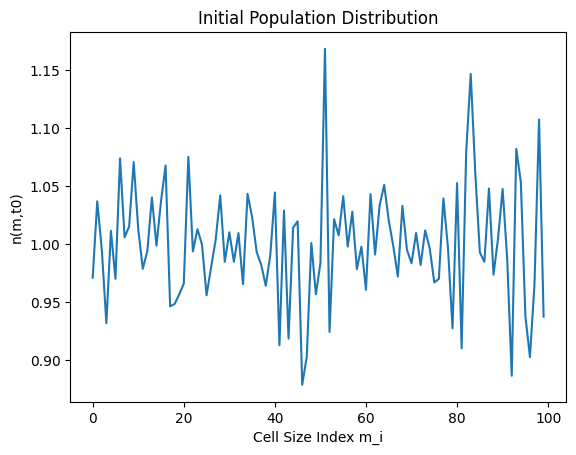

In [5]:
# Initial population n_i

n0 = [random.gauss(1.0, 0.05) for i in range(len(m))] #mean 1 , sigma=0.05
plt.plot(n0)
plt.title('Initial Population Distribution')
plt.xlabel('Cell Size Index m_i')
plt.ylabel('n(m,t0)')
plt.show()

                 # Normalize

# Initial substrate S
S0 = 5

# Combine into single initial condition vector
y0 = np.concatenate([n0, [S0]])

In [6]:
t_span = (0.0, 10.0)
timesteps=200
t_eval = np.linspace(*t_span, timesteps)

sol = solve_ivp(population_system, t_span, y0, t_eval=t_eval, method='RK45')


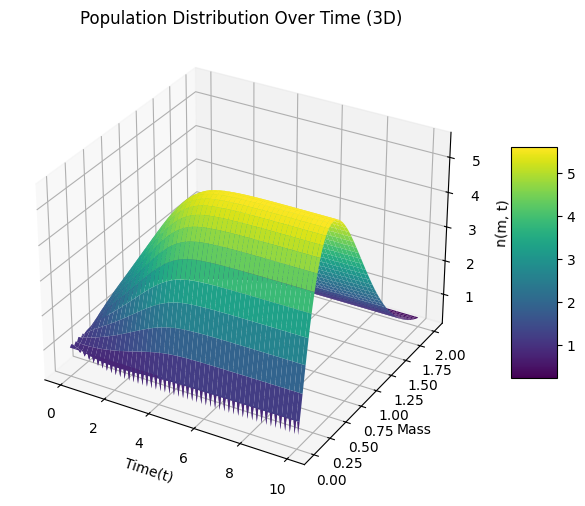

In [15]:
from mpl_toolkits.mplot3d import Axes3D

j=timesteps
# Create a meshgrid for mass (m) and time (t)
T, M_  = np.meshgrid(sol.t[:j], m)  

# Extract corresponding n(m, t) values for the first j time points
N = sol.y[:-1, :j]  # Transpose to match dimensions

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(T,M_ , N, cmap='viridis')

ax.set_xlabel('Time(t)')
ax.set_ylabel('Mass')
ax.set_zlabel('n(m, t)')
ax.set_title('Population Distribution Over Time (3D)')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

import plotly.graph_objects as go
import numpy as np

# T, M_, N are numpy arrays as before:
fig = go.Figure(data=[
    go.Surface(x=M_, y=T, z=N, colorscale='Viridis')
])
fig.update_layout(
    scene = dict(
        xaxis_title='Mass(m)',
        yaxis_title='Time (t)',
        zaxis_title='n(m, t)'
    ),
    width=600, height=600,
    title='Population Distribution Over Time'
)
fig.show()

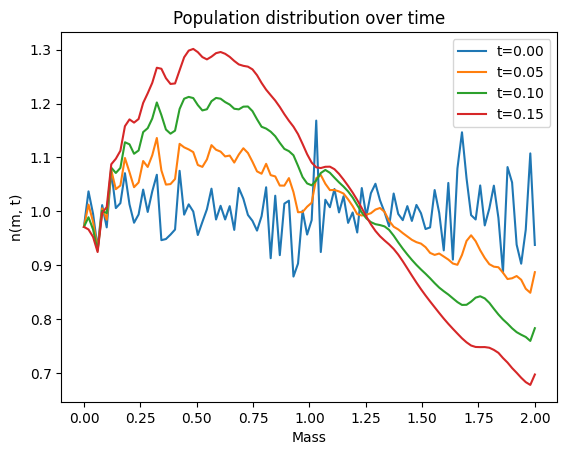

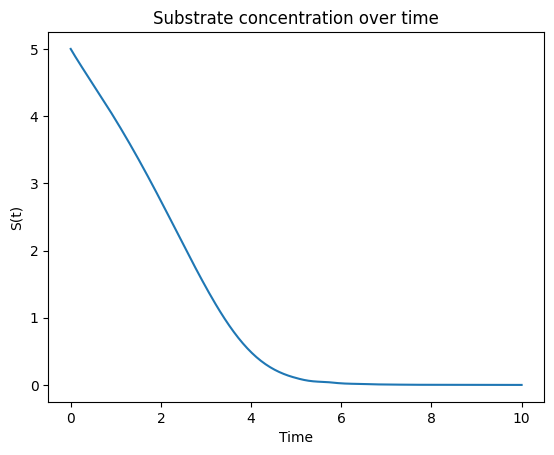

In [8]:


# Plot population distribution at different time steps
for idx in range(0,4):
    plt.plot(m, sol.y[:-1, idx], label=f't={sol.t[idx]:.2f}')
plt.xlabel('Mass')
plt.ylabel('n(m, t)')
plt.title('Population distribution over time')
plt.legend()
plt.show()

# Plot substrate over time
plt.plot(sol.t, sol.y[-1, :])
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Substrate concentration over time')
plt.show()


With the current (randomly chosen) rate $\Gamma$, larger cells/particles are affected a lot more, which is why the number of large cells decreases rapidly over time.


# Neural Network

In [9]:
'''
now we set up a neural network as a function f(n(m,t)) that serves sort of as a forward shift operator and allows us to get the 
value n(m, t+1). Since the System itself is not directly dependent on time, the training pairs for the model should be 
[n(m,t);n(m,t+1)],[n(m,t+1),n(m,t+2)]... 
the subsequent use of the function could then be used to compute the system state after an arbitrarily chosen time t, e.g
n(m,t+2)~   f(n(m,t+1))~    f(f(n(m,t)))
firstly we prepare the data:one part of the data will be used to train, the rest half for validation
to access the solution that was calculated with the original pDE at time t we use sol.y[:-1, t] for n(m,t) and sol.y[-1,t] for S(t) with t being the timestep we evaluated the pde at
'''
import torch as torch 
import torch.nn as nn


Xtrain = sol.y[:, 0:int(timesteps/4)-1].T  # shape: (timesteps-1, 101)
X_train = sol.y[:, 1:int(timesteps/4)].T   # shape: (timesteps-1, 101)
dim=(M)+1         #number of mass increments from m_min to m_max + 1 for the substrate concentration



#initializing the neural network class that inherits from nn
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),              #ReLU so no vanishing Gradient and also because it's pretty established...
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dim)      #the output layer adds 1 dimension (the substrate concentration that should also be estimated by this model!)
        )
    def forward(self, x):
        return self.model(x)

model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells

X_tensor = torch.tensor(Xtrain, dtype=torch.float32)
# print(X_tensor.shape)-->batch size,101

Y_tensor = torch.tensor(X_train, dtype=torch.float32)
# print(Y_tensor.shape)-->batch size,102 (the last column is the substrate concentration)

for epoch in range(2000): 
    optimizer.zero_grad()
    output = model(X_tensor)        #calls the forward function of the Neural Network class
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


#for visualization we need to detach the tensors from the computational graph (graph tracks gradients for backpropagation,
#but we only care for the numbers for plotting)
#you would propagate the model like this: i'll prbbly do it tomorrow in a loop as well as the error estimaton...
n01_pred = (model(torch.tensor(y0, dtype=torch.float32))).detach().numpy()

# plt.plot(n01_pred)


# plt.plot(sol.y[:-1,3]/n03_pred)



Epoch 0, Loss: 3.148183
Epoch 1000, Loss: 0.000084


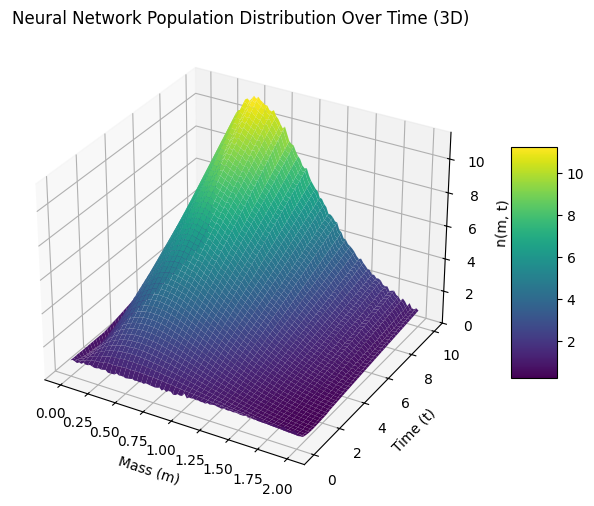

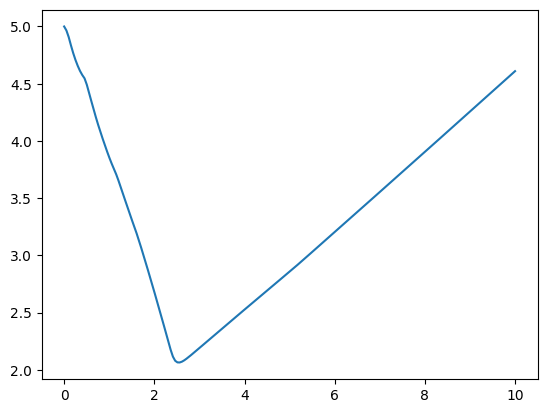

In [10]:
# Now we can use the model to predict the population distribution at future timesteps
solution=[y0]
for i in range (0,timesteps-1):
    
    nprev=solution[i]
    ni=model(torch.tensor(nprev[:],dtype=torch.float32)).detach().numpy()
    solution.append(ni)


# Prepare meshgrid for plotting
timesteps_nn = len(solution)
T_nn, M_nn = np.meshgrid(t_eval[:timesteps_nn], m)

# Convert solution list to numpy array and transpose for correct shape
N_nn = np.array(solution) [:,:-1] # shape: (timesteps_nn, len(m))-->Distribution of n(m,t) at each timestep


# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(M_nn.T, T_nn.T, N_nn, cmap='viridis')

ax.set_xlabel('Mass (m)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('n(m, t)')
ax.set_title('Neural Network Population Distribution Over Time (3D)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

#Substrate concentration:
plt.plot(t_eval[:timesteps],np.array(solution)[:,-1])
plt.show()

# Error estimation
Note that we only used our Model for the first half of the dataset that we calculated using the PDE so i only care about the mistake in the "predicted" part of the Neural Network, not the part that i specifically used the training data on.

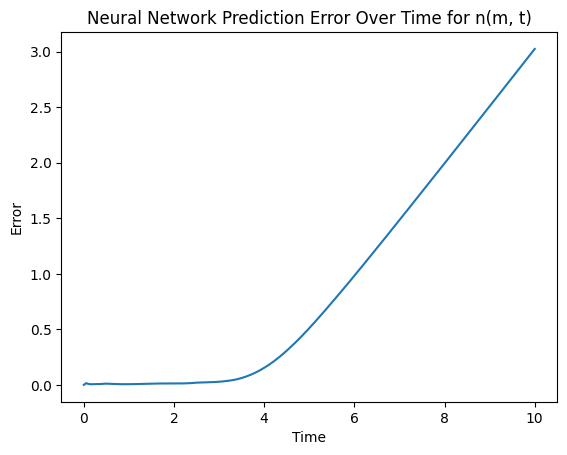

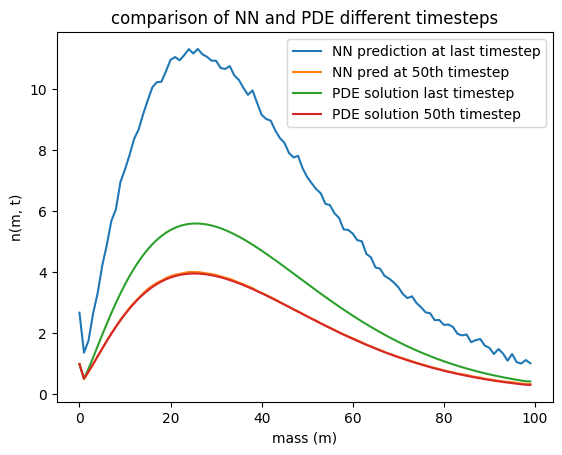

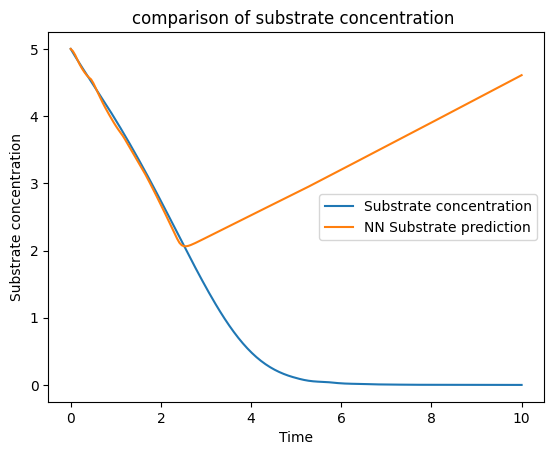

In [11]:
error=[]
# Calculate the error between the neural network predictions and the original solution (only for the Mass distribution!! not the substrate)
for i in range(timesteps_nn):
    er=0
    
    for j in range (M):
        er+= np.linalg.norm(N_nn[i, j] - sol.y[:-1, i][j])/(M)
    error.append(er)


# Plot error over time as a separate plot
plt.figure()
plt.plot(t_eval[:timesteps], error)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Neural Network Prediction Error Over Time for n(m, t)')
plt.show()

#
plt.figure()
plt.title('comparison of NN and PDE different timesteps')
plt.plot(N_nn[199])
plt.plot(N_nn[50])
plt.plot(sol.y[:-1, 199])
plt.plot(sol.y[:-1, 50])
plt.xlabel('mass (m)')
plt.ylabel('n(m, t)') 
plt.legend(['NN prediction at last timestep','NN pred at 50th timestep', 'PDE solution last timestep', 'PDE solution 50th timestep'])
plt.show()

plt.figure()
plt.title('comparison of substrate concentration ')
plt.plot(t_eval[:timesteps],sol.y[-1])
plt.plot(t_eval[:timesteps],np.array(solution)[:,-1])
plt.legend(['Substrate concentration','NN Substrate prediction'])
plt.xlabel('Time')
plt.ylabel('Substrate concentration')
plt.show()

# Conclusion
For this first attempt it appears that after we exceed the point of the training data, the model error grows rapidly. Obviously this is expected. However, it is noticable that after  the 50th timestep (approx at 2.5 seconds- the last timestep used for training), there is almost no change in the values estimated by the Neural Network. This can easily be observed in the Graph for the NN Substrate prediction

Why does this happen?

At first i was kind of expecting the NN to keep fitting the Data or at least fit the Data better, but since i only used 1 Dataset and only trained the model with  the first few seconds of that data, there was no training done using lower Substrate concentrations (as they would occur after timestep 50), so  the calculation of the DGL at lower Substrate concentrations simply would be outside the scope of the NN. To achieve better estimation i would need more training data that covers the entire range of possible substrate concentrations as well as a few more validation data sets.
The same obviously holds true for the $n(m,t)$ estimation.

Tldr:

- Not enough training Data
- Values are outside the scope of the NN




# Next step:

Increase the accuracy by using a ***Physics-informed Neural Network*** (PINN). In a PINN, the knowledge of physics of specific system behaviour is used to extend the Neural Network. For this, the loss function needs to be tailored to the differential equation one assumes could describe the system. I know it is not a "source", but Wikipedia also says that this type of NN is particularly helpful for partial differential equations. The PINN should then be better suited to describe the model, even slightly outside of the training interval. In general, the loss function for a PINN is constructed as follows:

Assume that the dataset originates from a system that can be described by a general PDE: 
$$
\frac{\partial n}{\partial t} = \frac{\partial n}{\partial m} + f(c)
$$
Solving for zero gives us:
$$
\frac{\partial n}{\partial t} - \frac{\partial n}{\partial m} - f(c) = 0
$$
and this is the part that will now be added to the loss function, so that
the loss function for the PINN becomes:
$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \lambda \, \mathcal{L}_{\text{PDE}}
$$
where $\mathcal{L}_{\text{data}}$ is the standard data loss (e.g., MSE between predicted and true values), $\mathcal{L}_{\text{PDE}}$ is the mean squared residual of the PDE:
$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^N \left| \left(\frac{\partial n}{\partial t}\right)_{\text{NN}} - \left(\frac{\partial n}{\partial m}\right)_{\text{NN}} - f(c) \right|^2
$$
and $\lambda$ is a weighting parameter that balances the two terms. This encourages the neural network to fit the data while also satisfying the underlying physics described by the PDE.


Here, $N$ represents the number of *collocation points*, i.e., the discrete points in the $(m, t)$ domain where the PDE residual is evaluated. 
Importantly, these collocation points do **not** have to coincide with the training data points; they can be chosen independently and even be sampled more densely or sparsely within the domain to enforce the physical constraints throughout the solution space. This flexibility allows the PINN to generalize the physical laws beyond just the observed data. Basically ensuring that the NN obeys the PDE across the whole domain